## Лабораторная работа  по биометрии №5
<div style="text-align: right"> 
    Чангалиди Антон, P3214
<br>
   Исследование данных Электроэнцефалографии
</div>

### Цель:
Освоение методов спектрального анализа ритма ЭЭГ.

### Задание:
1. На портале https://physionet.org/ в разделе Data найти раздел Neuroelectric and Myoelectric Databases.

2. В разделе Neuroelectric and Myoelectric Databases выбрать EEG During Mental Arithmetic Tasks

3. Ознакомиться с визуализатором Visualize waveforms

4. На любой из последовательности, выявить все альфа волны (см. 1 часть методички)

5. Произвести спектральный анализ (см. 2 часть методички)

6. Сделать выводы о возможности использования ЭЭГ для нейроинтерфейсов.

### Выполнение


In [26]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### 1-3. Работа с сайтом
Зашел, скачал, посмотрел два файла + построил электроэнцефалограмму в визуализаторе: 

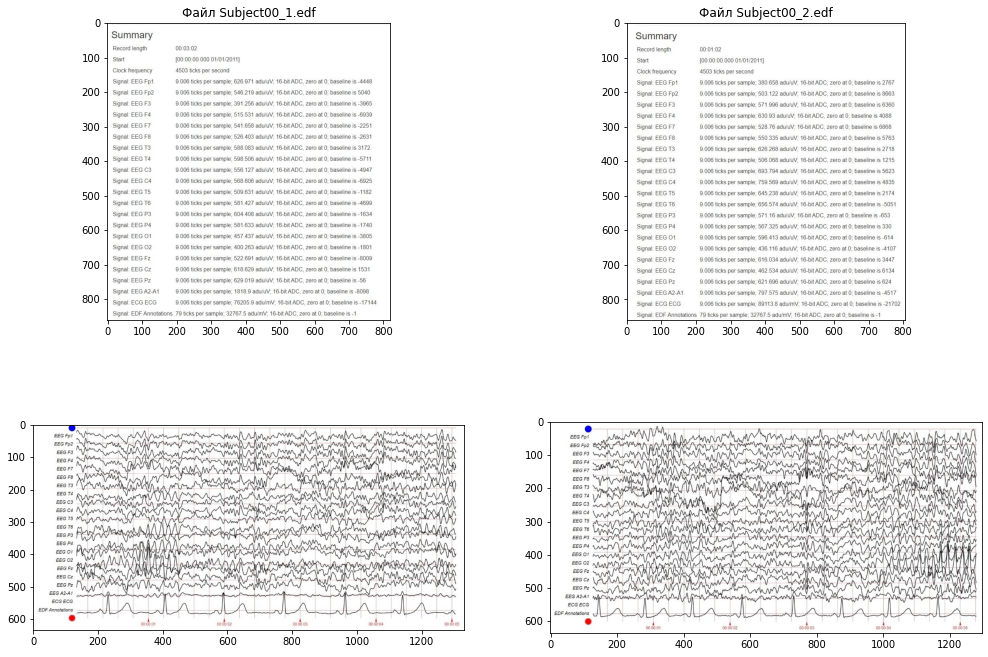

In [25]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(17)
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Файл Subject00_1.edf')
ax1.imshow(mpimg.imread('img/t1.png'))
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('Файл Subject00_2.edf')
ax2.imshow(mpimg.imread('img/t2.png'))
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(mpimg.imread('img/e1.png'))
ax4 = fig.add_subplot(2,2,4)
ax4.imshow(mpimg.imread('img/e2.png'))

(все файлы скачаны в 
#### Что это за файлы? 

Открываем readme файлик, и читаем:

The data files with EEG are provided in EDF (European Data Format) format. Each folder contains two recording files per subject: 
* with “_1” postfix -- the recording of the background EEG of a subject (before mental arithmetic task)
* with “_2” postfix -- the recording of EEG during the mental arithmetic task. 


Для дальнейшей работы с файлами понадобится библиотека:
```conda install -c conda-forge pyedflib```

### Выявление всех альфа-волн

#### Что это? 
Нормальная ритмическая активность ЭЭГ (расслабленное физическое и умственное состояние). 

__Частота альфа-ритма__ варьирует в пределах от 8 до 13 Гц. (Если частота больше, то активные процессы, меньше - сон/сонливость)

In [27]:
from pyedflib import highlevel

In [35]:
def read_edf(path):
    return highlevel.read_edf(path)

sample_1, sample_headers_1, header_1 = read_edf('physionet.org/files/eegmat/1.0.0/Subject00_1.edf')
sample_2, sample_headers_2, header_2 = read_edf('physionet.org/files/eegmat/1.0.0/Subject00_2.edf')

`samples` - сигналы

`sample_headers` - для каждой дорожки откуда измеряли, и статистики

`header` - метаинформация об эксперименте вцелом

In [47]:
sample_headers_2[1]['label']

'EEG Fp2'

In [57]:
# сделаю преобразование фурье
def fourier_transform(signals):
    f_signals = []
    for s in signals:
        n = len(s)
        f_signals.append(abs(np.fft.fft(s))[:n//2])
#     print(len(f_signals))
#     print(len(f_signals)//2)
#     print(len(np.array(f_signals)))
#     print(len(np.array(f_signals[:len(f_signals)//2])))
    return np.array(f_signals)

f_samples_1 = fourier_transform(sample_1)
f_samples_2 = fourier_transform(sample_2)

	BEFORE MATH



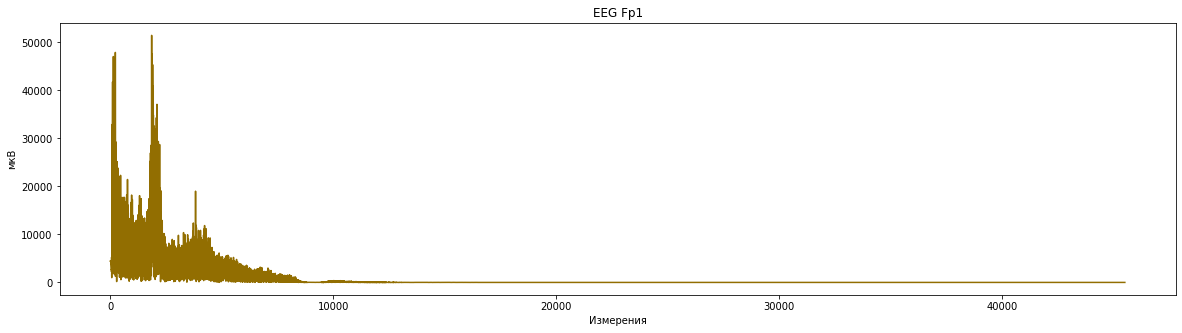

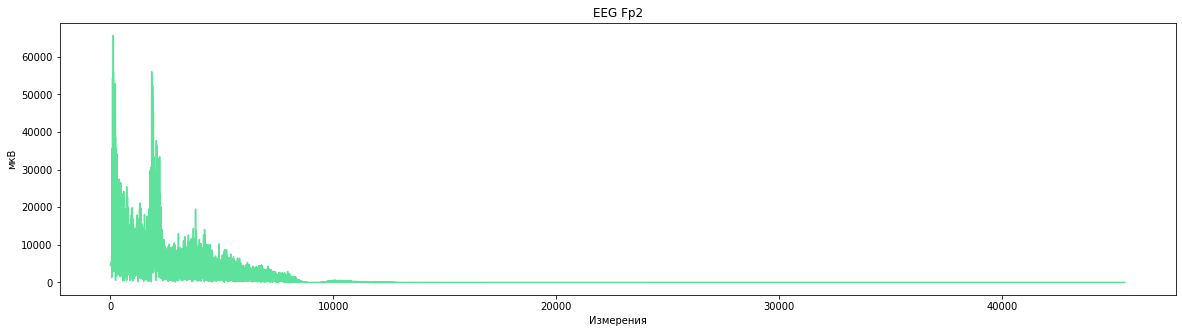

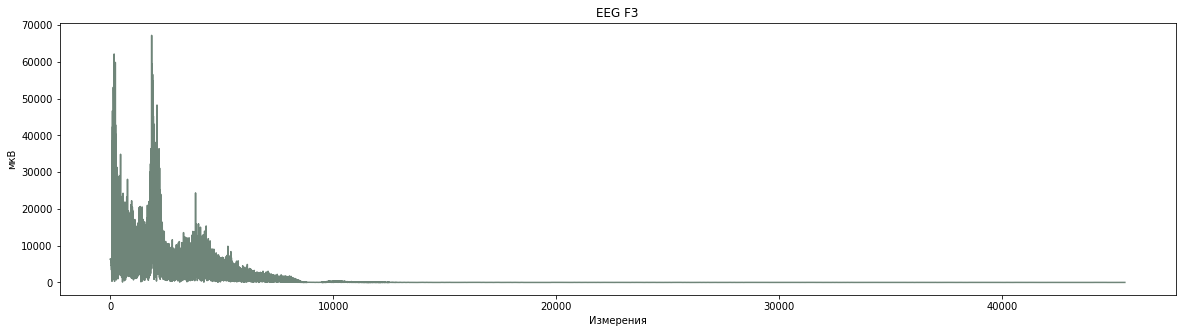

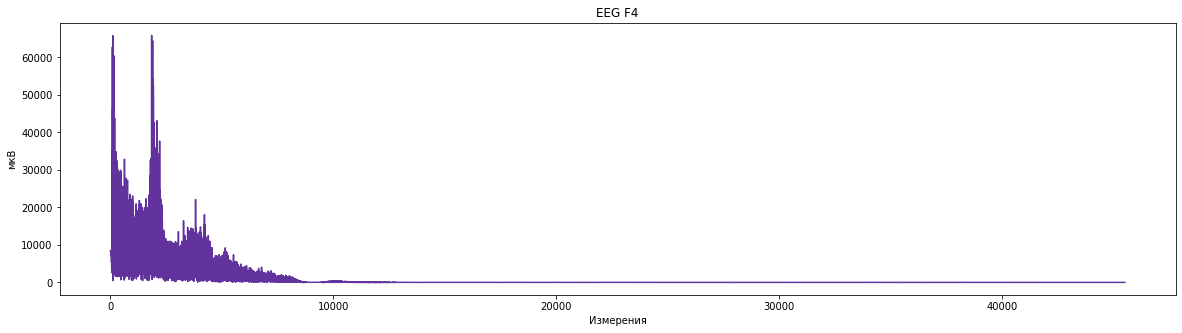

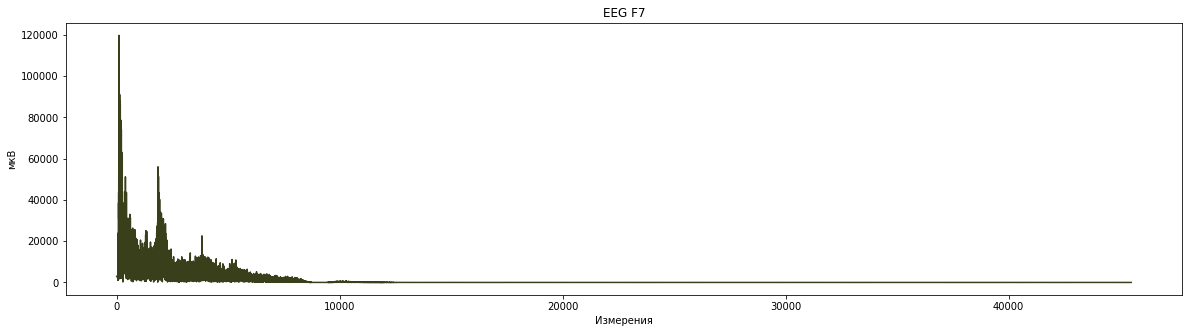

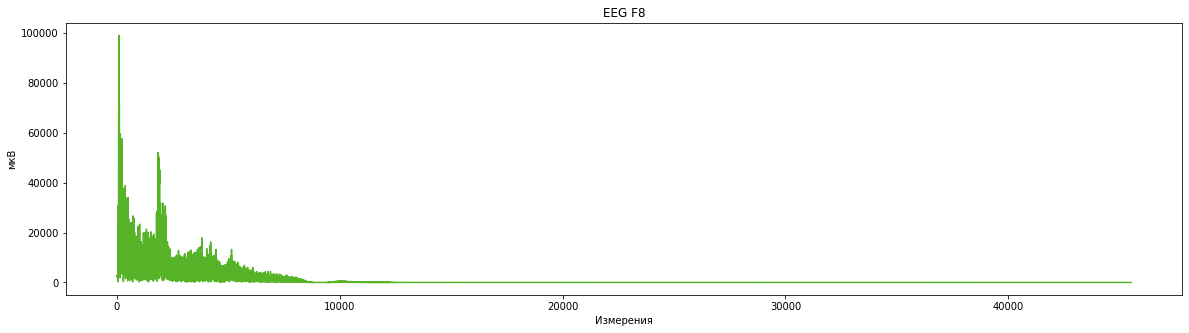

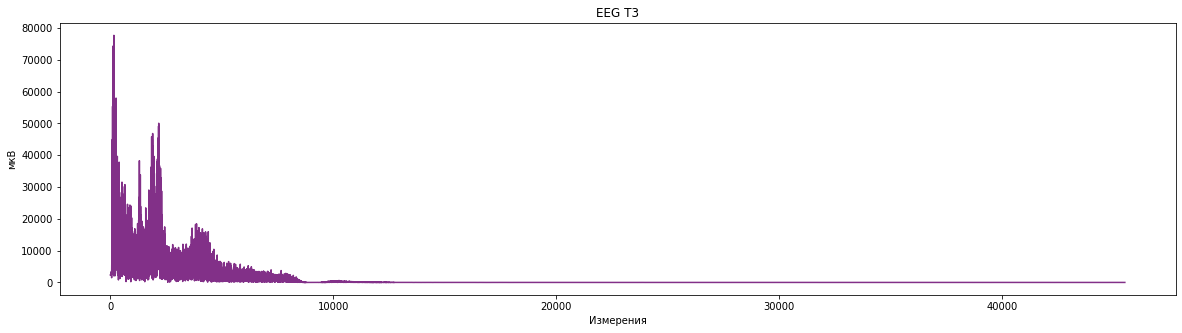

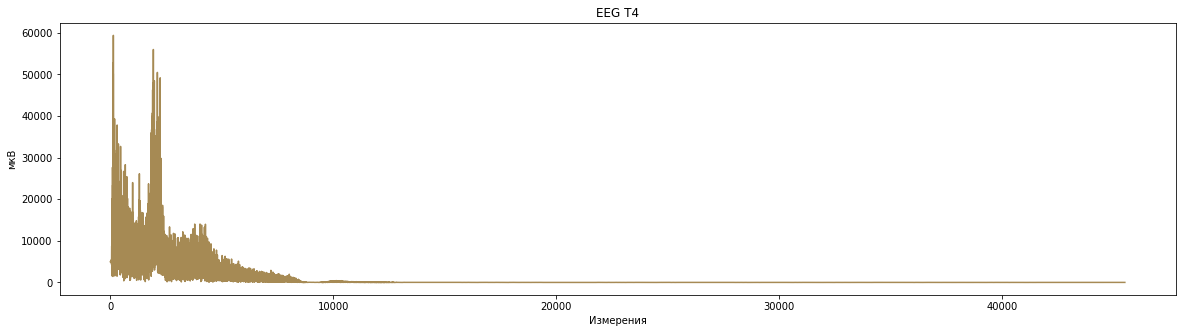

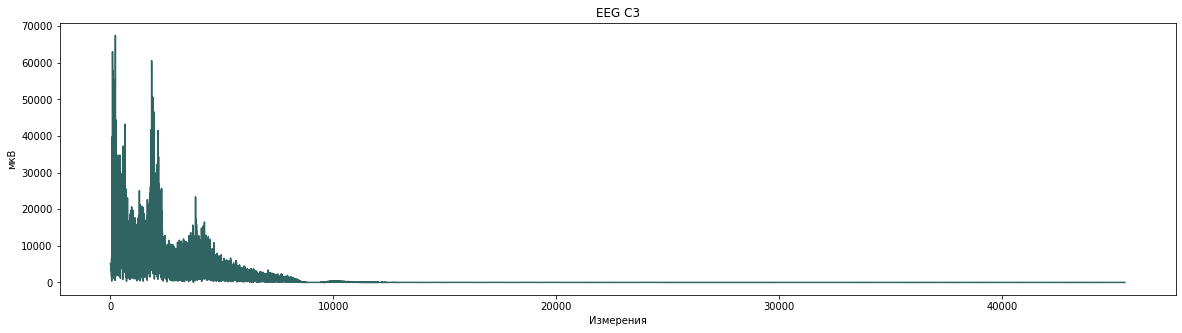

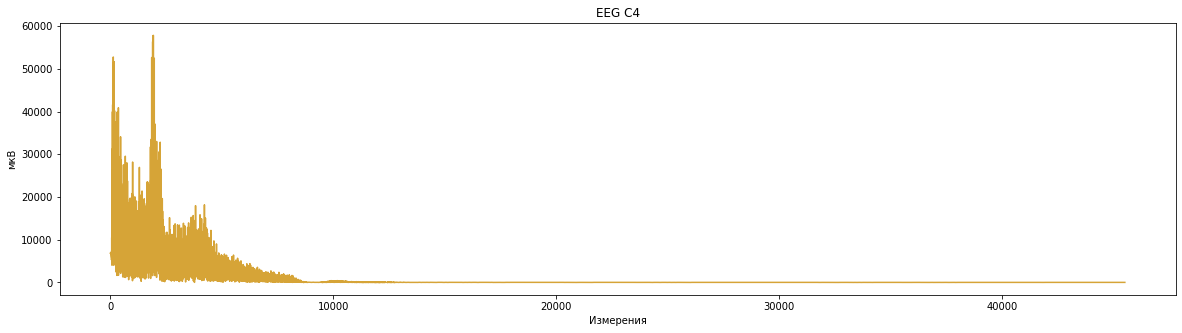

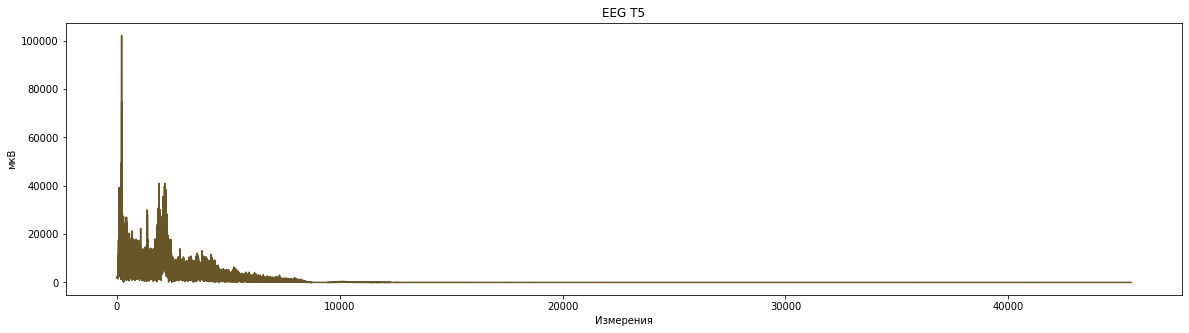

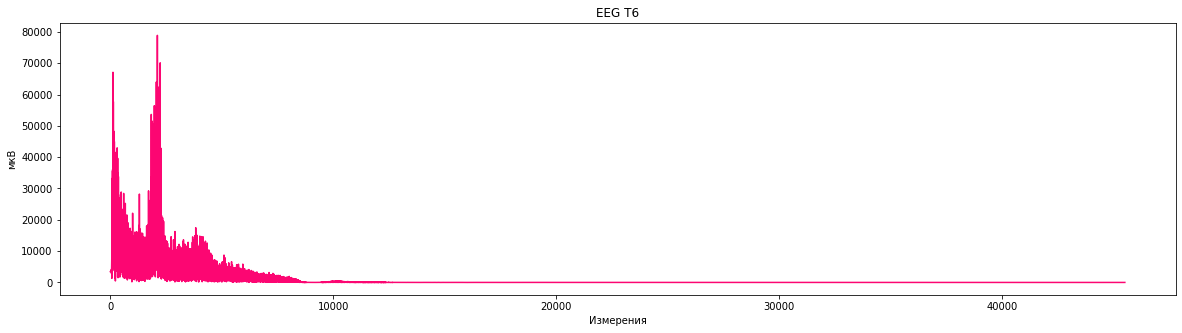

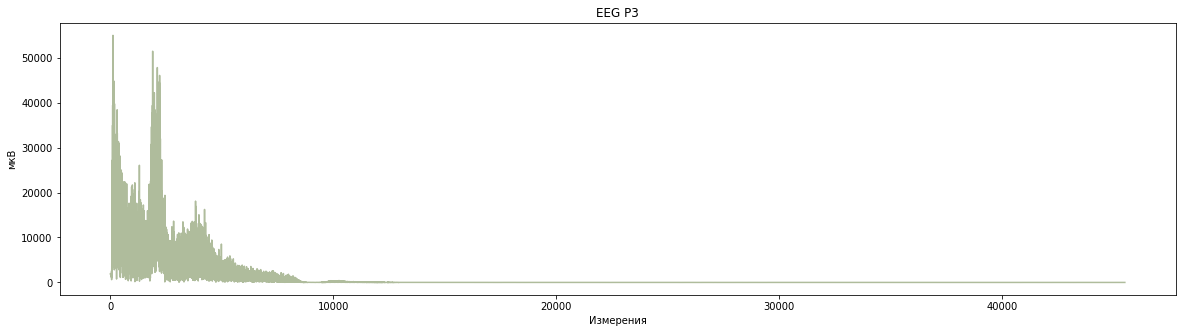

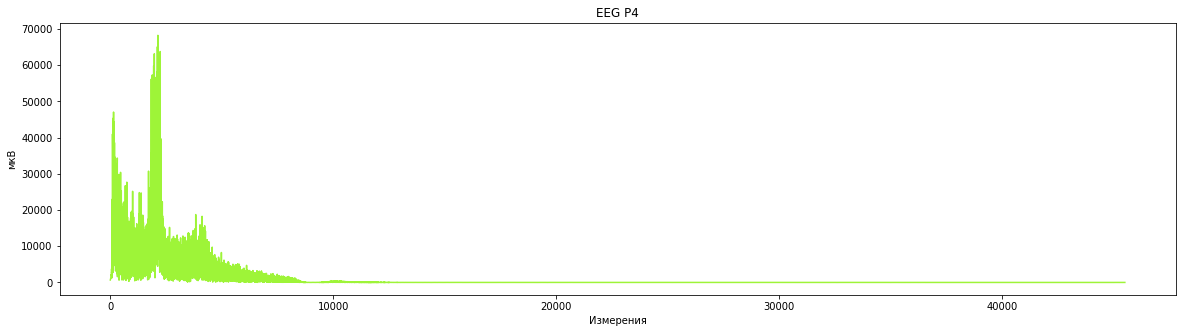

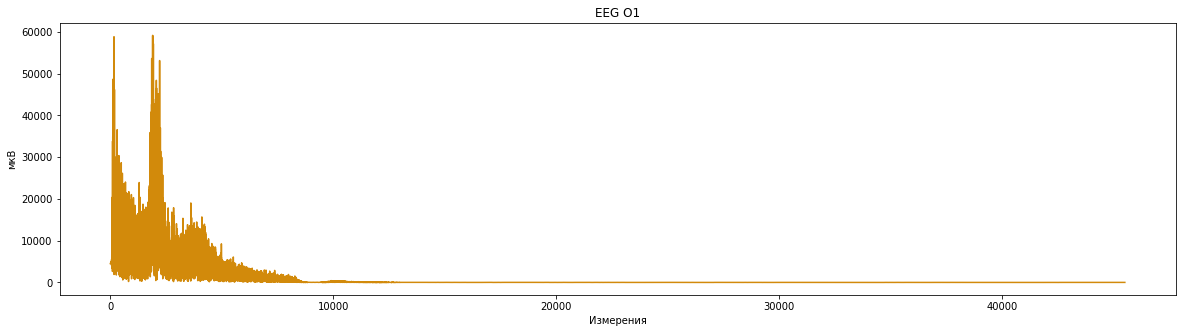

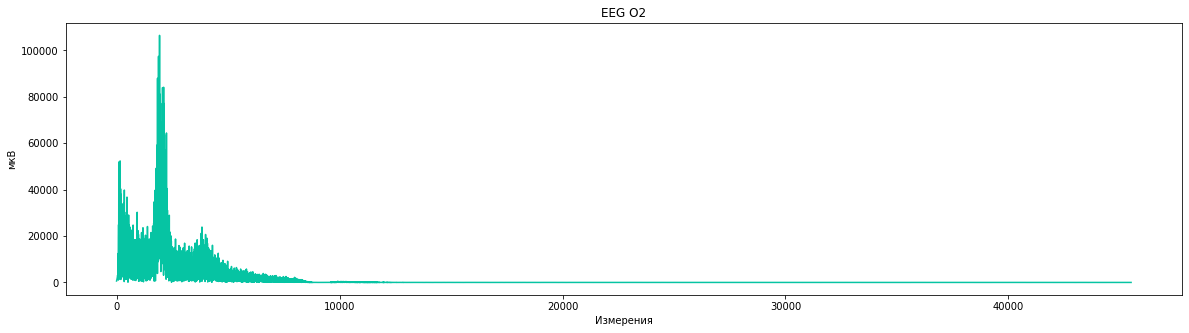

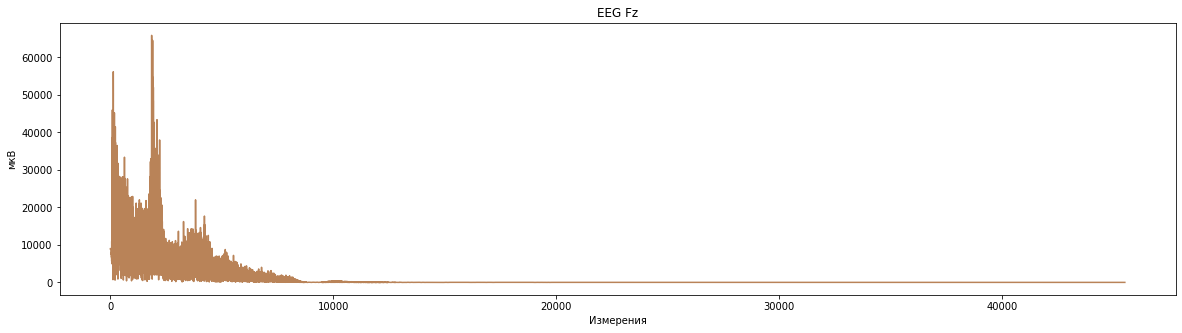

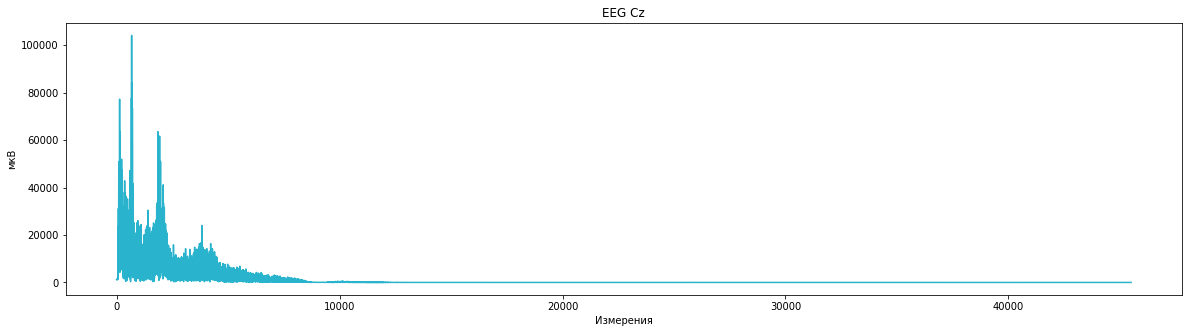

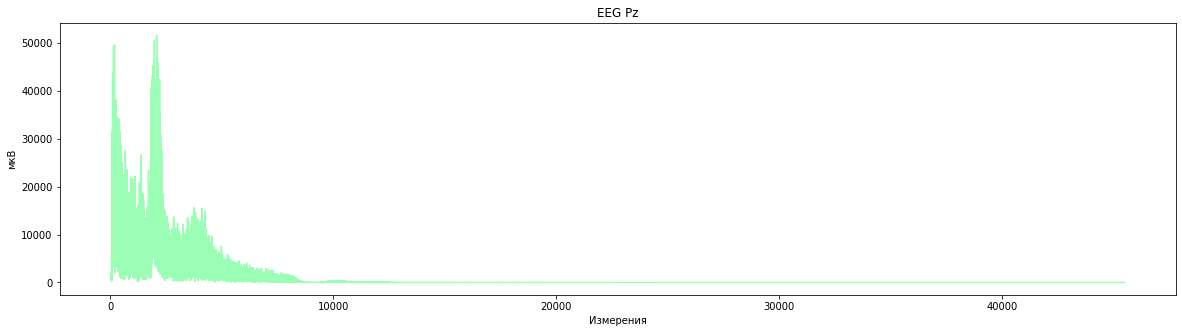

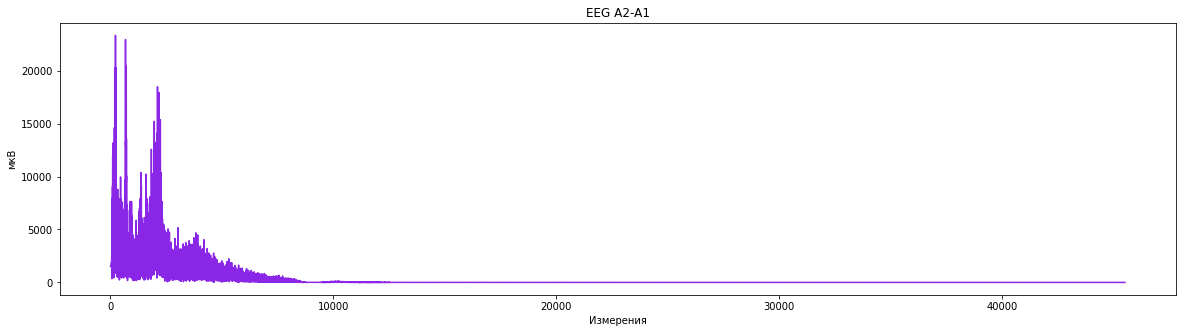

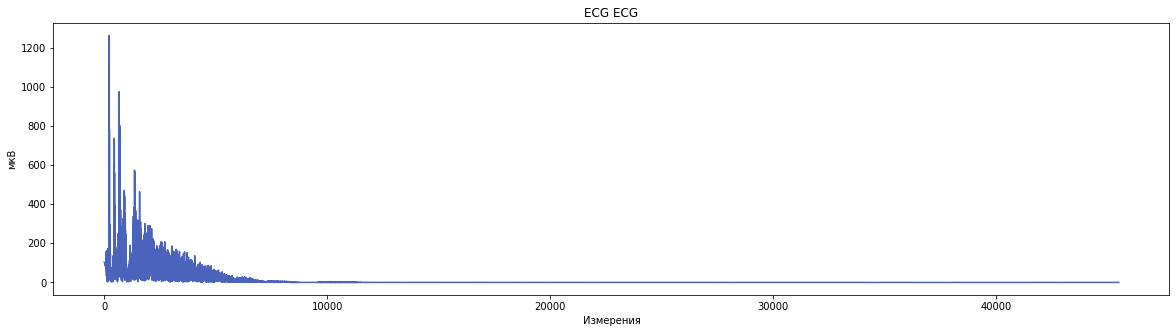

	AFTER MATH



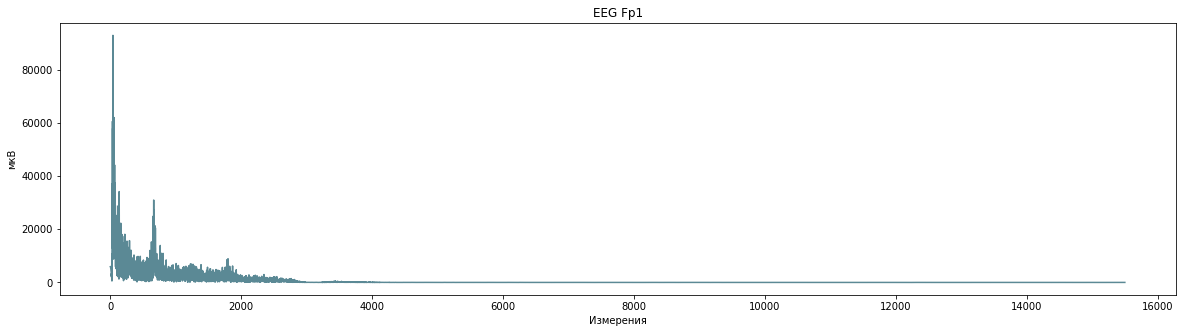

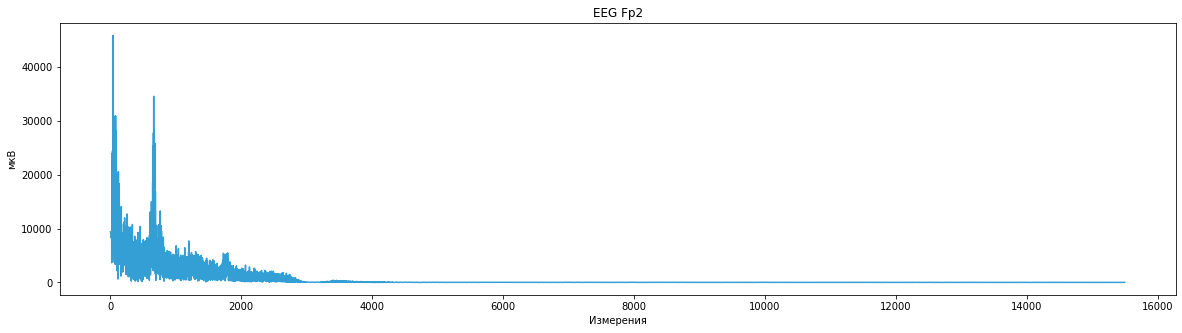

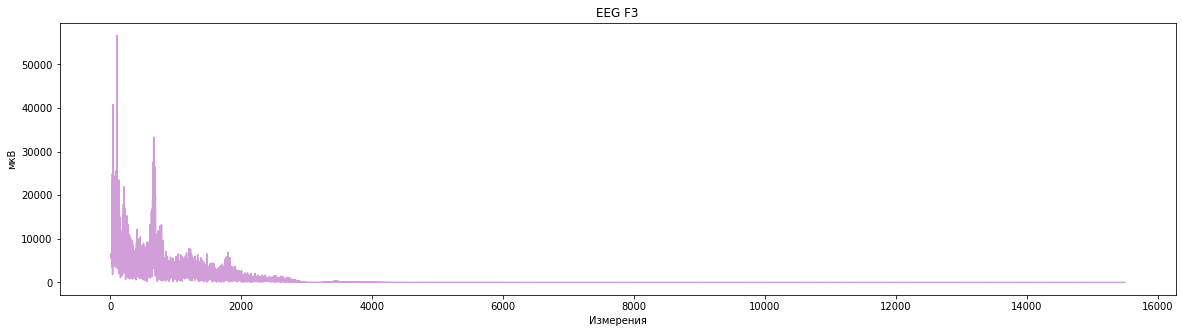

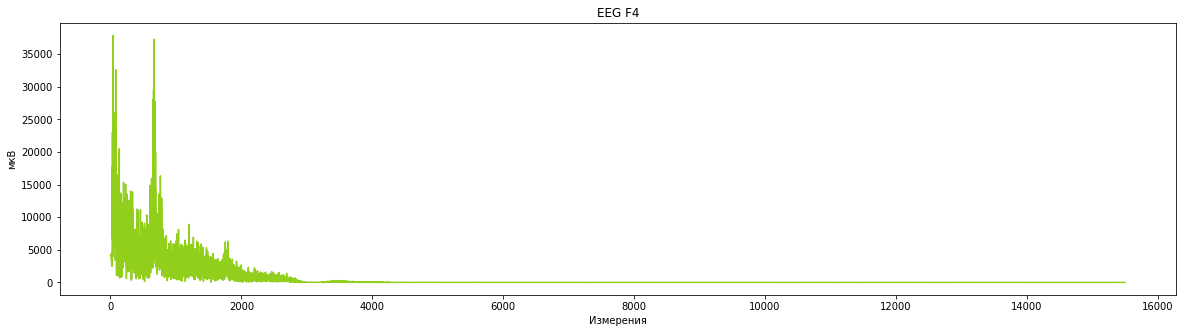

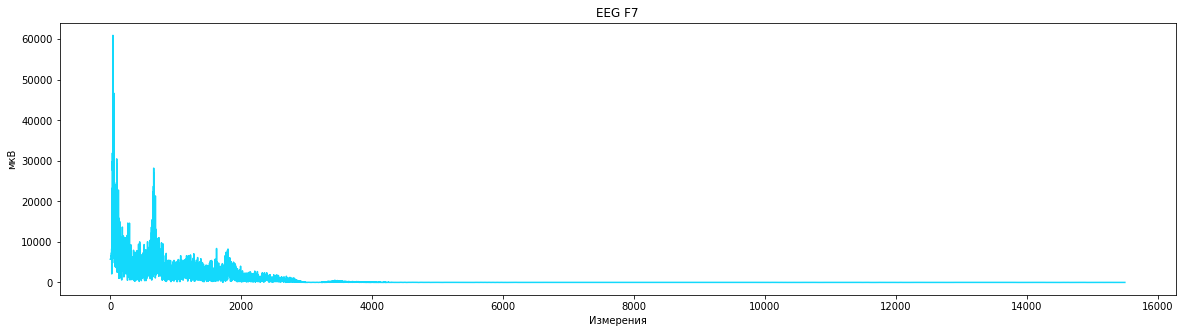

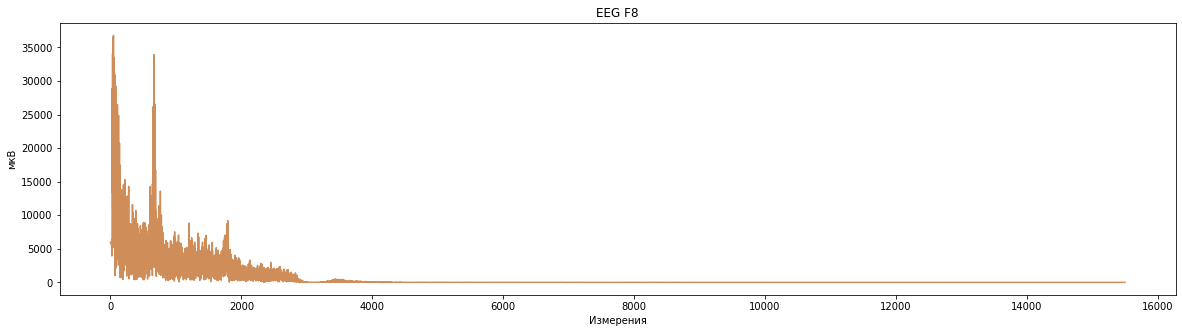

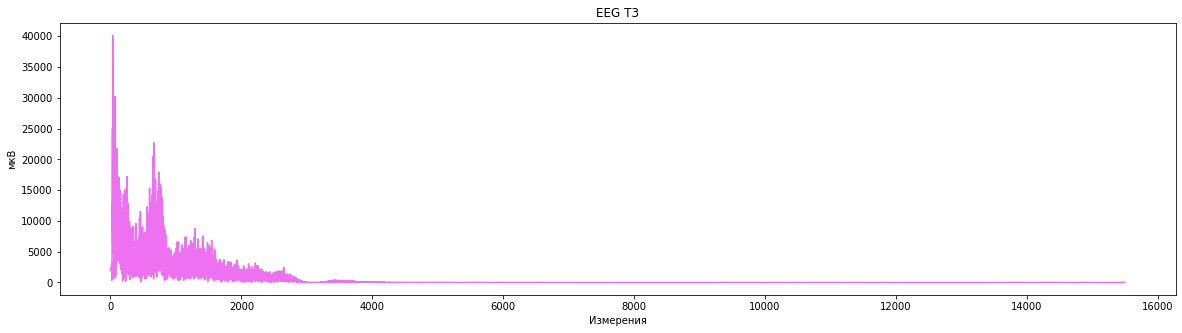

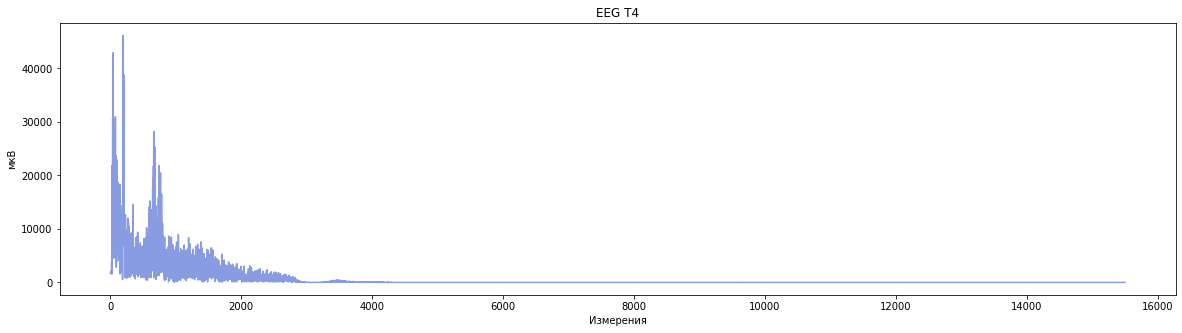

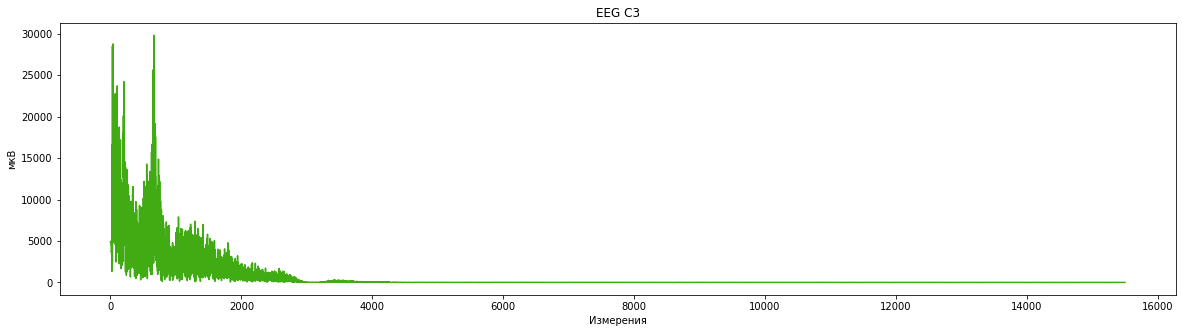

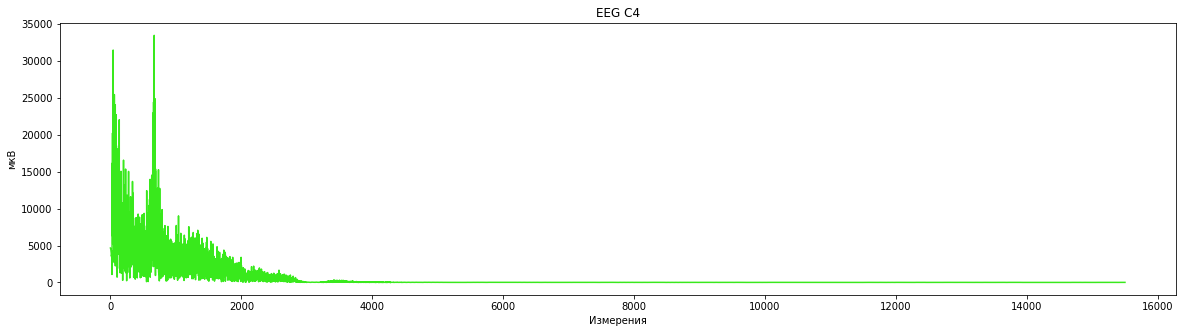

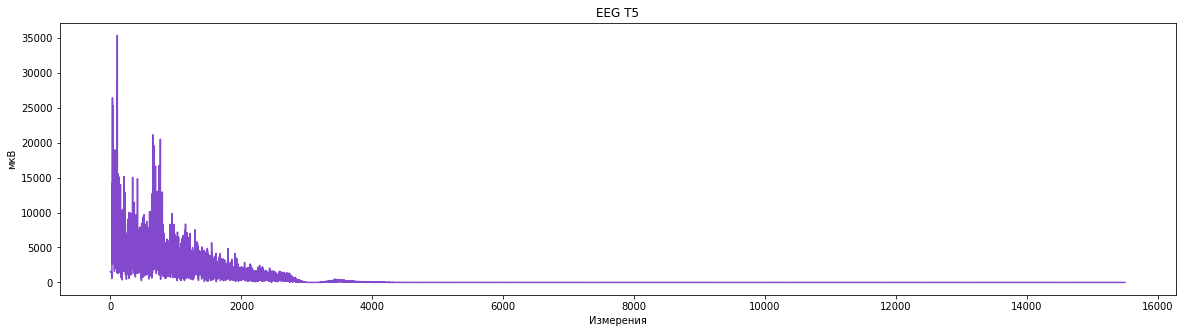

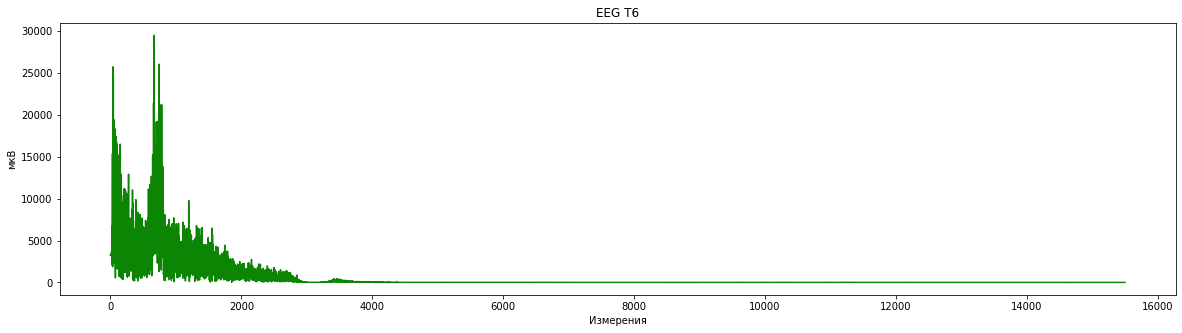

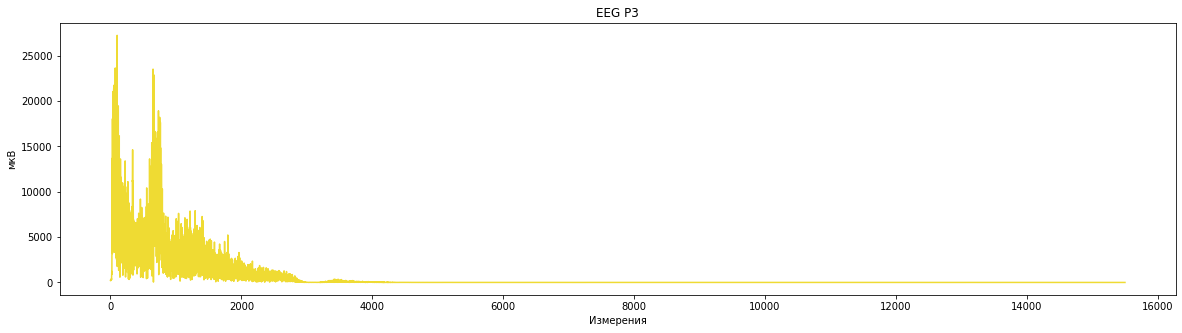

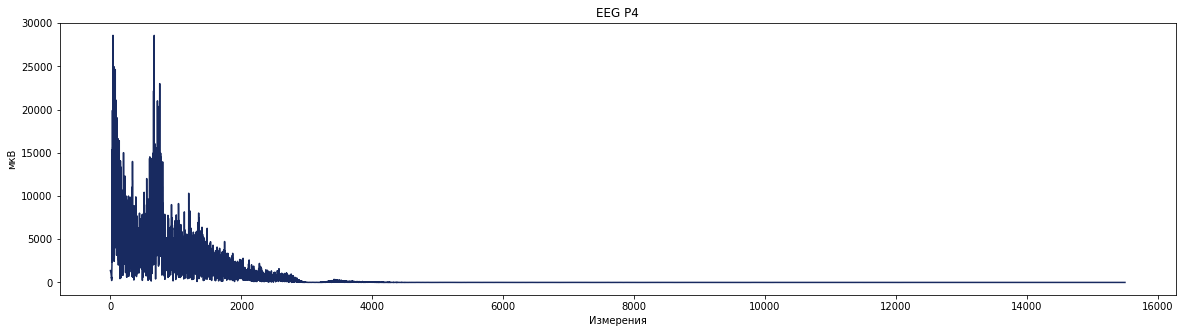

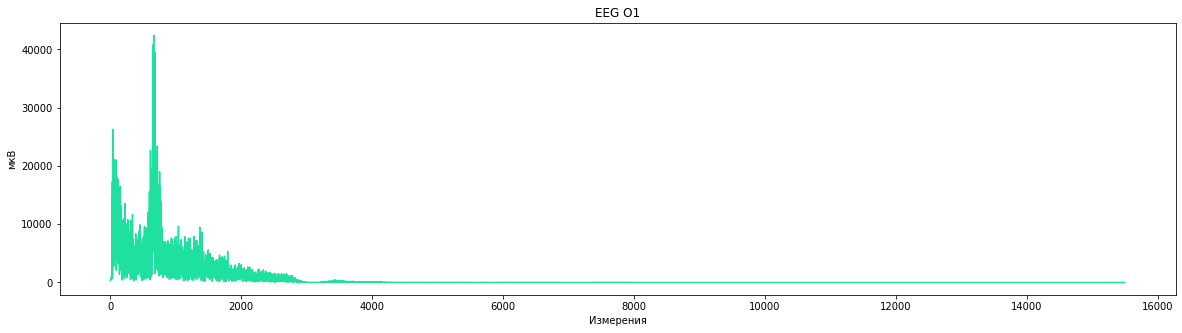

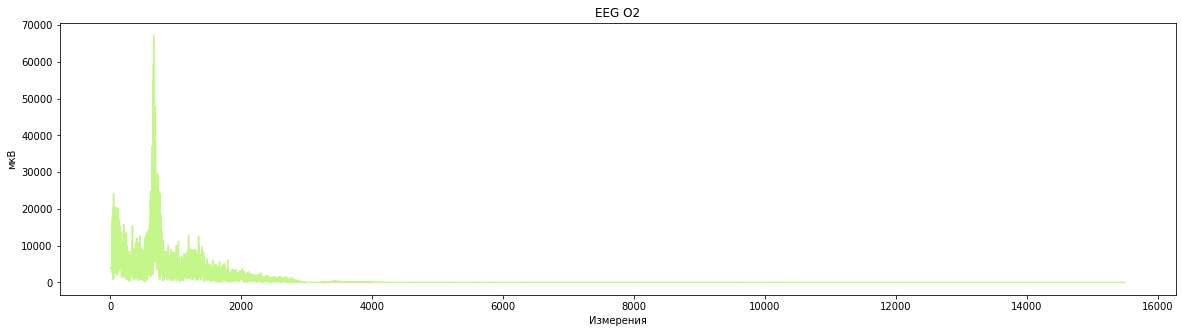

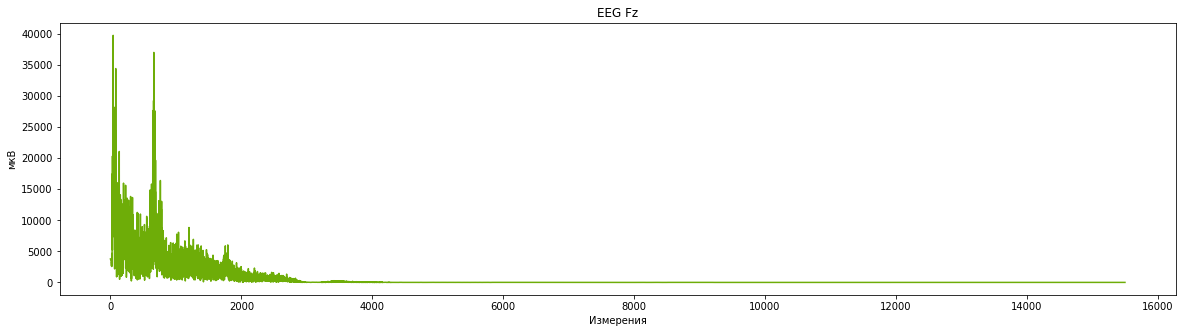

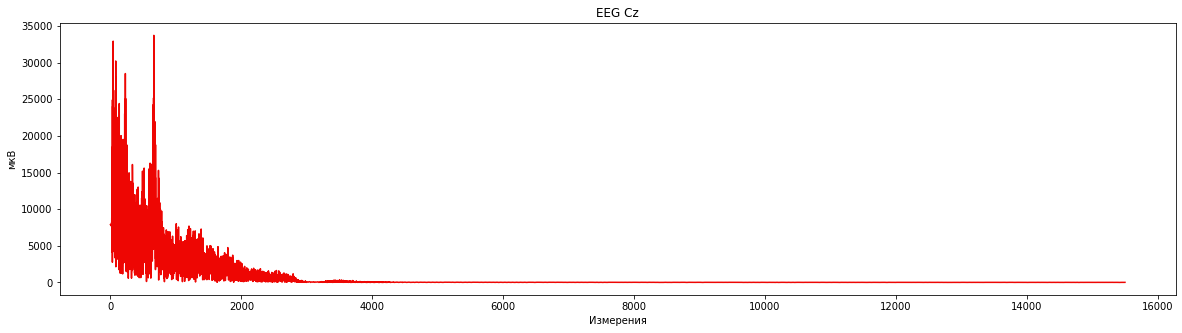

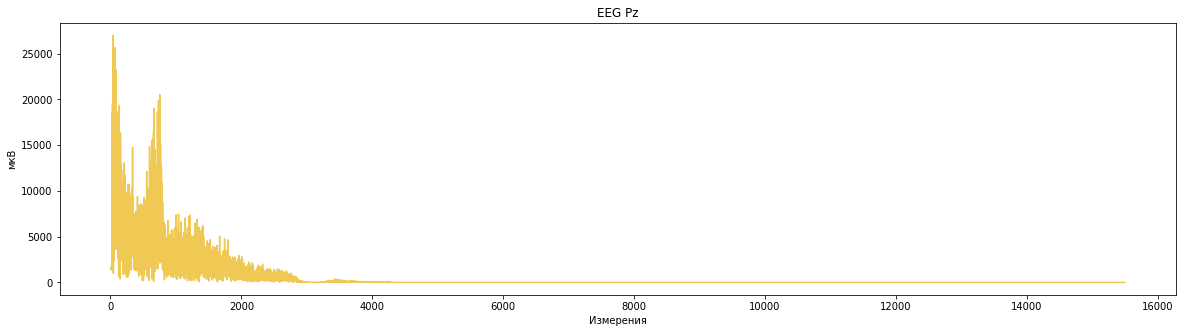

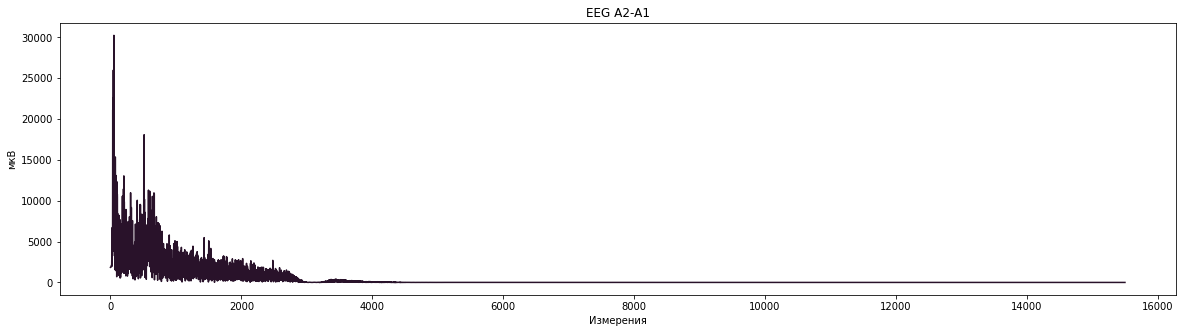

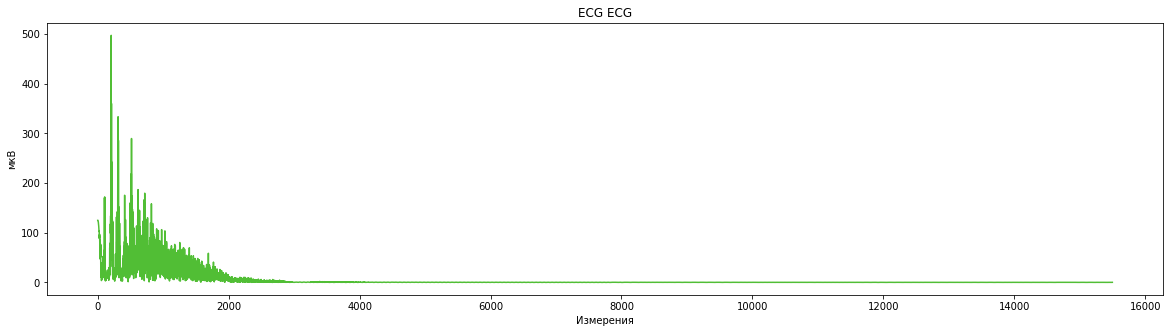

In [74]:
# draw them
def draw_signals(f_signals, xlabel = '', ylabel = '', title = ''):
#     f_signals = f_signals[f_signals>30]
    plt.figure(figsize=(20, 5))
    plt.plot(f_signals, c=np.random.rand(3,))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def draw_for_sample(f_samples, sample_headers, name):
    print('=================================\n\t'+name.upper()+'\n=================================\n')
    for sample, head in zip(f_samples, sample_headers):
        draw_signals(sample, 'Измерения', 'мкВ', head['label'])
        
draw_for_sample(f_samples_1, sample_headers_1, 'before math')
draw_for_sample(f_samples_2, sample_headers_2, 'after math')

### Спектральный анализ

### Выводы
Сделать выводы о возможности использования ЭЭГ для нейроинтерфейсов.